In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io as scipy
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import label as connected_components
from ipywidgets import interact, Dropdown
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA, NMF

ims_cube = scipy.loadmat("ims_cube.mat")['ims_cube']

# 1. Data Understanding
## 1.1 Plot der räumlichen Verteilung einzelner Features/Kanäle
*Beim Dropdown "Channels" lassen sich je 6 Bilder oder auch alle auf einmal ausgeben:*

In [2]:
# Print basic information
print(f"Shape of ims_cube: {ims_cube.shape}")

n_channels = ims_cube.shape[2]
print(f"Number of channels: {n_channels}")

# Plot channels
def plot_channels(preset_group):
    # Plot all channels in a dynamic grid
    if preset_group == "All Channels":
        channels_to_show = list(range(n_channels))
        cols = 4  # Adjust as needed
        rows = (n_channels + cols - 1) // cols  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
        
        # Handle different subplot configurations
        if n_channels == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if hasattr(axes, '__iter__') else [axes]
        else:
            axes = axes.ravel()
        
        for i, channel_idx in enumerate(channels_to_show):
            im = axes[i].imshow(ims_cube[:, :, channel_idx], cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx + 1}')  # Changed to 1-based indexing
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i])
        
        # Hide unused subplots
        for i in range(n_channels, rows * cols):
            if i < len(axes):
                axes[i].set_visible(False)

    # Plot up to 6 plots at once
    else:
        # Parse the preset group to get channel range
        group_start = int(preset_group.split('-')[0]) - 1  # 0-based indexing
        group_end = min(group_start + 6, n_channels)
        channels_to_show = list(range(group_start, group_end))
        
        cols = 3
        rows = 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        axes = axes.ravel()
        
        for i, channel_idx in enumerate(channels_to_show):
            im = axes[i].imshow(ims_cube[:, :, channel_idx], cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx + 1}')  # 1-based indexing
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i])
        
        # Hide unused subplots
        for i in range(len(channels_to_show), 6):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create preset groups
preset_options = ["All Channels"] 
for i in range(0, n_channels, 6):
    start = i + 1
    end = min(i + 6, n_channels)
    preset_options.append(f"{start}-{end}")

# Create widget
preset_selector = Dropdown(
    options=preset_options,
    value=preset_options[1], 
    description='Channels:',
    disabled=False,
)

# Interactive widget
interact(plot_channels, preset_group=preset_selector)

Shape of ims_cube: (128, 128, 191)
Number of channels: 191


interactive(children=(Dropdown(description='Channels:', index=1, options=('All Channels', '1-6', '7-12', '13-1…

<function __main__.plot_channels(preset_group)>

## 1.2 Plot der enthaltenen Spektren


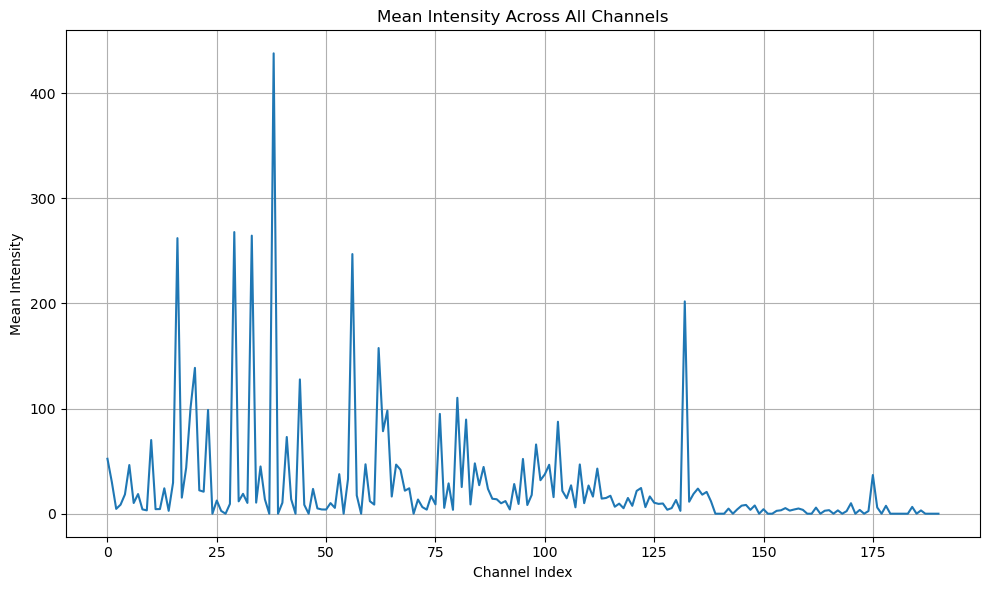

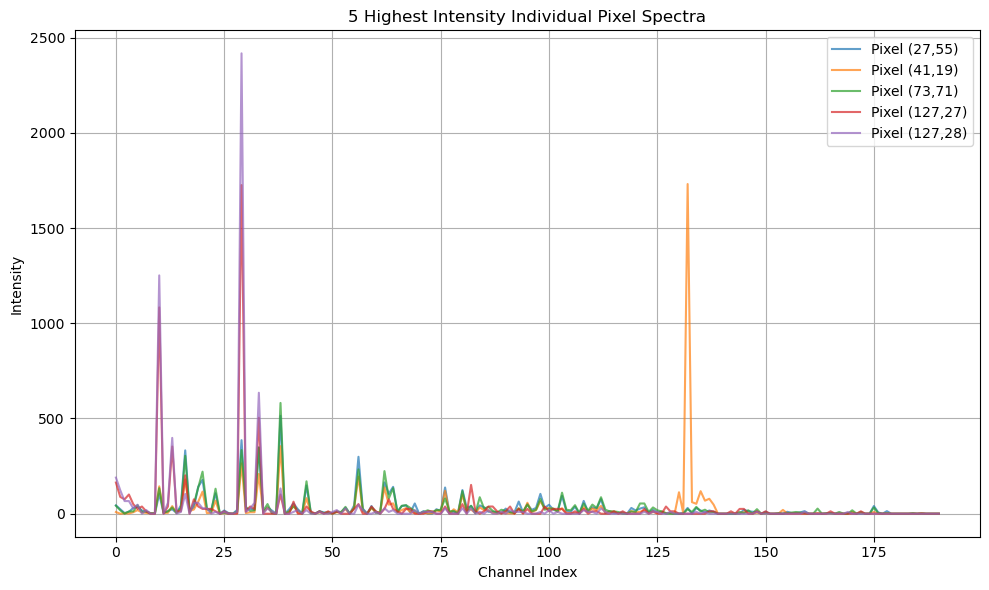

In [3]:
# Plot mean intensity across all channels
plt.figure(figsize=(10, 6))
mean_intensity = np.mean(ims_cube, axis=(0, 1))
plt.plot(mean_intensity)
plt.title('Mean Intensity Across All Channels')
plt.xlabel('Channel Index')
plt.ylabel('Mean Intensity')
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot spectra for the highest peaks (possibly most interesting)
plt.figure(figsize=(10, 6))
n_samples = 5

# Extract height and width from ims_cube shape
height, width = ims_cube.shape[:2]

# Find pixels with highest overall intensity
pixel_sums = np.sum(ims_cube, axis=2)  # Sum across all channels for each pixel
flat_indices = np.argsort(pixel_sums.ravel())[-n_samples:]  # Get top n_samples pixels

for i, flat_idx in enumerate(flat_indices):
    # Convert flat index back to 2D coordinates
    row, col = np.unravel_index(flat_idx, (height, width))
    spectrum = ims_cube[row, col, :]
    plt.plot(spectrum, alpha=0.7, label=f'Pixel ({row},{col})')

plt.title('5 Highest Intensity Individual Pixel Spectra')
plt.xlabel('Channel Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Eckdaten zur Spektralanalyse

#### a) für das durchschnittliche Spektrum:

In [4]:
print(f"=== AVERAGE SPECTRUM SPECTRAL ANALYSIS ===\n")
print(f"Min intensity: {np.min(mean_intensity):.3f}")
print(f"Max intensity: {np.max(mean_intensity):.3f}")
print(f"Mean intensity: {np.mean(mean_intensity):.3f}")
print(f"Std deviation: {np.std(mean_intensity):.3f}")

# Find peaks
peak_indices = []
for i in range(1, len(mean_intensity)-1):
    if mean_intensity[i] > mean_intensity[i-1] and mean_intensity[i] > mean_intensity[i+1]:
        peak_indices.append(i)

if peak_indices:
    peak_values = mean_intensity[peak_indices]
    # Get top 3 peaks
    top_peaks_idx = np.argsort(peak_values)[-3:][::-1]
    top_peak_channels = [peak_indices[i] for i in top_peaks_idx]
    top_peak_values = [peak_values[i] for i in top_peaks_idx]
    print(f"Top peaks at channels: {top_peak_channels} "
          f"with values: {[f'{val:.3f}' for val in top_peak_values]}")

# Find global maximum
max_channel = np.argmax(mean_intensity)
print(f"Global maximum at channel {max_channel}: {mean_intensity[max_channel]:.3f}")

# Find global minimum
min_channel = np.argmin(mean_intensity)
print(f"Global minimum at channel {min_channel}: {mean_intensity[min_channel]:.3f}")


=== AVERAGE SPECTRUM SPECTRAL ANALYSIS ===

Min intensity: 0.000
Max intensity: 437.762
Mean intensity: 27.321
Std deviation: 54.405
Top peaks at channels: [38, 29, 33] with values: ['437.762', '267.803', '264.411']
Global maximum at channel 38: 437.762
Global minimum at channel 24: 0.000


#### b) für den gesamten Datensatz:

In [5]:
print("=== DATASET OVERVIEW ===")
print(f"Total number of spectra (pixels): {height * width}")
print(f"Number of spectral channels: {n_channels}")
print(f"Overall min intensity: {np.min(ims_cube):.3f}")
print(f"Overall max intensity: {np.max(ims_cube):.3f}")
print(f"Overall mean intensity: {np.mean(ims_cube):.3f}")
print(f"Overall std deviation: {np.std(ims_cube):.3f}")
print()


# Channel-wise statistics
channel_means = np.mean(ims_cube, axis=(0,1))
channel_stds = np.std(ims_cube, axis=(0,1))

most_variable_channel = np.argmax(channel_stds)
least_variable_channel = np.argmin(channel_stds)

print(f"Most variable channel: {most_variable_channel} (std: {channel_stds[most_variable_channel]:.3f})")
print(f"Least variable channel: {least_variable_channel} (std: {channel_stds[least_variable_channel]:.3f})")

=== DATASET OVERVIEW ===
Total number of spectra (pixels): 16384
Number of spectral channels: 191
Overall min intensity: 0.000
Overall max intensity: 2417.062
Overall mean intensity: 27.321
Overall std deviation: 64.665

Most variable channel: 132 (std: 405.127)
Least variable channel: 24 (std: 0.000)


## 1.3 Erkenntnisse aus der Datenanalyse

| **Beobachtung** | **Konsequenz für die Datenverarbeitung** |
| :--- | :--- |
| *Datenformat* (Dimension) | Die 128x128-Bilder müssen in eine 2D-Matrix umgewandelt werden, damit sie verarbeitet werden können (für Clustering, PCA, usw. zwingend nötig). |
| *Dynamikbereich*: Große Amplitudenunterschiede | *Normalisierung/Standardisierung*: Skalierung der Daten ist zwingend, um sicherzustellen, dass alle Features / Dimensionen gleich behandelt werden |
| *Heterogenität*: Kanäle zeigen unterschiedliche räumliche Muster | ggf. *Feature Selection* zur Identifikation der informativsten Kanäle |
| *Korrelation*: Ähnliche Strukturen deuten auf Redundanz hin | ggf. *Dimensionsreduktion* zur Entfernung redundanter Informationen |


# 2. Data Preparation
## 2.1 Datenumformung

### Umwandlung des 3D-Datenwürfels in eine 2D Matrix

In [6]:
# Reshape data cube into 2D matrix (samples x features)
# Each pixel becomes a sample, each channel becomes a feature

print(f"Original shape: {ims_cube.shape}")

X = ims_cube.reshape(-1, n_channels)

print(f"Reshaped matrix shape: {X.shape}")
print(f"Number of samples (pixels): {X.shape[0]}")
print(f"Number of features (channels): {X.shape[1]}")

# Verify the transformation
print(f"\nVerification:")
print(f"Original total pixels: {height} * {width} = {height * width}")
print(f"Matrix samples: {X.shape[0]}")

Original shape: (128, 128, 191)
Reshaped matrix shape: (16384, 191)
Number of samples (pixels): 16384
Number of features (channels): 191

Verification:
Original total pixels: 128 * 128 = 16384
Matrix samples: 16384


## 2.2 Datenstandardisierung

### Zentrierung auf Mittelwert Null und Skalierung auf Einheitsvarianz

In [7]:
# Standardize the features with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Standardized matrix shape: {X_scaled.shape}\n")

# Verify standardization per feature
print(f"Verifying with example values (first 15):")
print(" Per-feature means:", np.round(np.mean(X_scaled, axis=0)[:15],3))
print(" Per-feature stds:", np.std(X_scaled, axis=0)[:15])

Standardized matrix shape: (16384, 191)

Verifying with example values (first 15):
 Per-feature means: [ 0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0.]
 Per-feature stds: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 3. Modeling & Evaluation: Clustering
## 3.1 Verfahrensauswahl
### Modellierung: k-Means Clustering für MSI-Daten

| Aspekt | k-Means Clustering (Ausgewähltes Verfahren) | Alternative Verfahren (DBSCAN, GMM, Hierarchical, etc.) |
| :--- | :--- | :--- |
| **Grundprinzip** | Gruppiert bei MSI-Daten alle Pixel in eine vorher festgelegte Anzahl (k) von Clustern, die jeweils ein bestimmtes Material oder Gewebe repräsentieren sollen. Dabei wird jedes Pixel dem Cluster-Zentrum zugeordnet, dessen durchschnittliches Spektrum seinem eigenen Spektrum am ähnlichsten ist. Durch diesen iterativen Prozess entstehen am Ende stabile Gruppen von Pixeln mit sehr ähnlichen spektralen Signaturen. | Nutzen andere Metriken wie Dichte (DBSCAN) oder Wahrscheinlichkeitsverteilungen (GMM). |
| **Eignung für MSI** | **Sehr gut**: Spektrale Ähnlichkeit wird direkt in geringe Distanz übersetzt. Cluster-Zentren sind als "typische" Materialspektren interpretierbar. | **Weniger geeignet**:<br>- DBSCAN hat Schwierigkeiten mit hochdimensionalen Daten und der Parameterwahl (ε).<br>- GMM ist komplexer ohne klaren Vorteil. |
| **Skalierbarkeit** | **Hoch**: Effiziente Komplexität ($O(n \cdot k \cdot i)$) ideal für große MSI-Datensätze mit vielen Pixeln. | **Gering**: <br>- Hierarchical Clustering ($O(n^3)$)<br>- DBSCAN ($O(n^2)$)<br>-  Spectral Clustering ($O(n^3)$)<br> ->sind alle für große Datenmengen zu rechenintensiv. |
| **Parameter** | **Einfach**: Im Wesentlichen muss nur die Anzahl der Cluster (k) bestimmt werden, welche in diesem Anwendungsbeispiel durch Domänenwissen gegeben ist. | **Komplex**: DBSCAN (ε, min_samples), GMM (Anzahl, Kovarianzen) und Spectral Clustering erfordern eine aufwändigere Parameterwahl. |
| **Annahmen** | **Passend**: Annahmen wie sphärische und konvexe Cluster werden durch die Standardisierung der Daten gut unterstützt. | - |
| **Vorteile** | Schnelle Verarbeitung<br>Leicht interpretierbare Ergebnisse<br>Robust bei standardisierten Daten<br>Etabliertes Verfahren | - |
| **Nachteile** | Kann bei stark überlappenden Spektren oder Rauschen an Grenzen stoßen. | Meist zu langsam oder unpraktikabel für die Analyse von MSI-Bildern. |

## 3.2 Parametrisierung

#### k=5, da in der Aufgabe die Rede von 5 Gewebearten ist

### Alternativ: k über Silhouette Score festlegen

=== K-MEANS PARAMETER OPTIMIZATION ===
Testing different values of k to find optimal number of clusters...
k=2: Silhouette Score = 0.2527
k=3: Silhouette Score = 0.2125
k=4: Silhouette Score = 0.1321
k=5: Silhouette Score = 0.1278
k=6: Silhouette Score = 0.1034
k=7: Silhouette Score = 0.0934
k=8: Silhouette Score = 0.0715
k=9: Silhouette Score = 0.0710
k=10: Silhouette Score = 0.0660

Optimal k based on silhouette score: 2 (score: 0.2527)


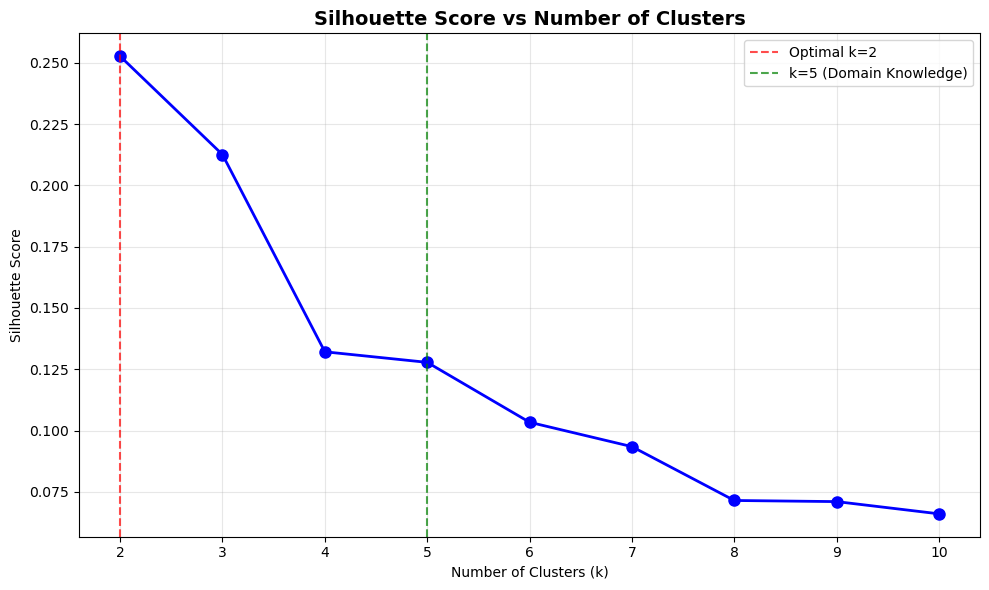

In [ ]:
# First, let's do k-means parameter optimization to find the best k
print(f"=== K-MEANS PARAMETER OPTIMIZATION ===")
print("Testing different values of k to find optimal number of clusters...")

k_range = range(2, 11)  # Test k from 2 to 10
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k} (score: {max(silhouette_scores):.4f})")

# Plot optimization results
plt.figure(figsize=(10, 6))

# Silhouette scores
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.axvline(x=5, color='green', linestyle='--', alpha=0.7, label='k=5 (Domain Knowledge)')
plt.title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Auswertung Silhouette Score
Ginge man rein nach dem Silhouette Score, müsste man k=2 oder k=3 wählen. Da 2 Cluster in diesem Kontext wenig Sinn ergeben, lohnt sich eher noch das Ergebnis mit 3 Clustern anzuschauen.

## 3.3 Durchführung und Visualisierung

=== K-MEANS CLUSTERING ANALYSIS ===
Using k=5 clusters as specified
Data shape: (16384, 191)

Silhouette Score: 0.1278

Cluster Distribution:
  Cluster 1: 3,830 pixels (23.4%)
  Cluster 2: 532 pixels (3.2%)
  Cluster 3: 3,463 pixels (21.1%)
  Cluster 4: 6,473 pixels (39.5%)
  Cluster 5: 2,086 pixels (12.7%)


Text(0, 0.5, 'Y coordinate (pixels)')

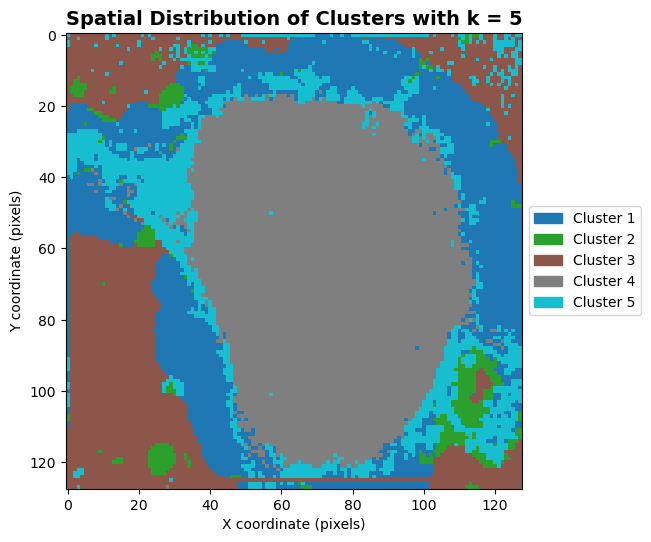

In [51]:
# Perform k-means clustering with k=5
print("=== K-MEANS CLUSTERING ANALYSIS ===")
print(f"Using k=5 clusters as specified")
print(f"Data shape: {X_scaled.shape}")

# Perform clustering
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_avg = silhouette_score(X_scaled, labels)

print(f"\nSilhouette Score: {silhouette_avg:.4f}")

# Analyze cluster distribution
unique_labels, counts_k5 = np.unique(labels, return_counts=True)
print(f"\nCluster Distribution:")
for label, count in zip(unique_labels, counts_k5):
    percentage = count/len(labels)*100
    print(f"  Cluster {label + 1}: {count:,} pixels ({percentage:.1f}%)")

# Reshape labels back to spatial dimensions for visualization
image_width = ims_cube.shape[1]
labels_spatial_k5 = labels.reshape(height, image_width)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Main cluster map
ax1 = plt.subplot(2, 3, 1)
cluster_map = plt.imshow(labels_spatial_k5, cmap='tab10', interpolation='nearest')
plt.title('Spatial Distribution of Clusters with k = 5', fontsize=14, fontweight='bold')

# Create custom legend with cluster labels
colors = plt.cm.tab10(np.linspace(0, 1, 5))
legend_elements = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(5)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')


In [50]:
print("=== INDIVIDUAL CLUSTER VISUALIZATIONS ===\n")

# Interactive widget for individual cluster selection
def show_individual_cluster(cluster_id):
    plt.figure(figsize=(10, 6)) 
    
    # Mask for the selected cluster
    cluster_mask = (labels_spatial_k5 == cluster_id).astype(float)
    cluster_mask[cluster_mask == 0] = np.nan  # transprent background
    
    plt.imshow(cluster_mask, cmap='Blues', alpha=1, interpolation='nearest', 
               vmin=0, vmax=1)
    plt.title(f'Cluster {cluster_id + 1}\n({counts_k5[cluster_id]:,} pixels, {counts_k5[cluster_id]/len(labels)*100:.1f}%)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('X coordinate (pixels)')
    plt.ylabel('Y coordinate (pixels)')
    
    # Replace colorbar with custom legend
    #cluster_patch = mpatches.Patch(color='blue', label=f'Cluster {cluster_id + 1}')
    #background_patch = mpatches.Patch(color='white', label='Background')
    #plt.legend(handles=[cluster_patch], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Additional cluster statistics
    print(f"\n=== CLUSTER {cluster_id + 1} DETAILS ===")
    print(f"Number of pixels: {counts_k5[cluster_id]:,}")
    print(f"Percentage of total: {counts_k5[cluster_id]/len(labels)*100:.2f}%")
    
    # Find connected components for spatial coherence analysis
    cluster_binary = (labels_spatial_k5 == cluster_id).astype(int)
    labeled_array, num_components = connected_components(cluster_binary)
    
    if num_components > 0:
        component_sizes = np.bincount(labeled_array.flat)[1:]  # Exclude background (0)
        largest_component = np.max(component_sizes)
        
        print(f"\nNumber of separate components: {num_components}")
        print(f"Largest component size: {largest_component} pixels")
        print(f"Average component size: {np.mean(component_sizes):.1f} pixels")

# Create interactive widget
cluster_dropdown = Dropdown(
    options=[(f'Cluster {i+1}', i) for i in range(5)],
    value=0,
    description='Cluster:',
    disabled=False,
)

print("\n=== INTERACTIVE CLUSTER EXPLORER ===")
interact(show_individual_cluster, cluster_id=cluster_dropdown)

=== INDIVIDUAL CLUSTER VISUALIZATIONS ===


=== INTERACTIVE CLUSTER EXPLORER ===


interactive(children=(Dropdown(description='Cluster:', options=(('Cluster 1', 0), ('Cluster 2', 1), ('Cluster …

<function __main__.show_individual_cluster(cluster_id)>

=== K-MEANS CLUSTERING ANALYSIS ===
Using k=3 clusters
Data shape: (16384, 191)

Silhouette Score: 0.2125

Cluster Distribution:
  Cluster 1: 10,608 pixels (64.7%)
  Cluster 2: 2,153 pixels (13.1%)
  Cluster 3: 3,623 pixels (22.1%)


Text(0, 0.5, 'Y coordinate (pixels)')

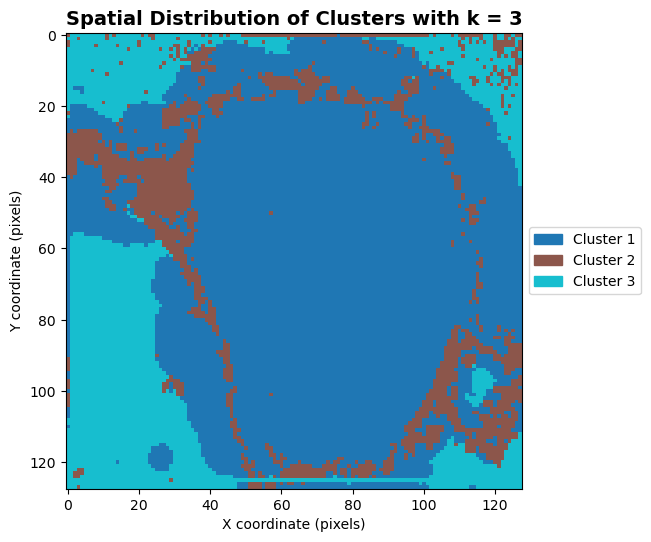

In [48]:
# Perform k-means clustering with k=3
print("=== K-MEANS CLUSTERING ANALYSIS ===")
print(f"Using k=3 clusters")
print(f"Data shape: {X_scaled.shape}")

# Perform clustering
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_avg = silhouette_score(X_scaled, labels)

print(f"\nSilhouette Score: {silhouette_avg:.4f}")

# Analyze cluster distribution
unique_labels, counts_k3 = np.unique(labels, return_counts=True)
print(f"\nCluster Distribution:")
for label, count in zip(unique_labels, counts_k3):
    percentage = count/len(labels)*100
    print(f"  Cluster {label + 1}: {count:,} pixels ({percentage:.1f}%)")

# Reshape labels back to spatial dimensions for visualization
image_width = ims_cube.shape[1]
labels_spatial_k3 = labels.reshape(height, image_width)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Main cluster map
ax1 = plt.subplot(2, 3, 1)
cluster_map = plt.imshow(labels_spatial_k3, cmap='tab10', interpolation='nearest')
plt.title('Spatial Distribution of Clusters with k = 3', fontsize=14, fontweight='bold')

# Create custom legend with cluster labels
colors = plt.cm.tab10(np.linspace(0, 1, 3))
legend_elements = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(3)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')


## 3.4 Ergebnisse

Es wurden zwei Optionen durchgeführt. Eine mit k=3 nach einer Silhouette Score Analyse und eine mit k=5 nach Domänenwissen.

#### Hier nun die Auswertung für das Ergebnis mit k=5:
Die Cluster zeigen eine recht deutliche räumliche Strukturierung im Bild:
* Ein großes zentrales Cluster (Cluster 3, grau) dominiert den inneren Bereich der Probe.
* Cluster 1 und 5 (blaue Farbtöne) umgeben diesen Bereich ringförmig.
* Kleinere grüne Flächen (Cluster 2) treten verstreut an den Rändern auf.
* Cluster 4 (braun) findet sich hauptsächlich im äußeren Bereich der Probe.

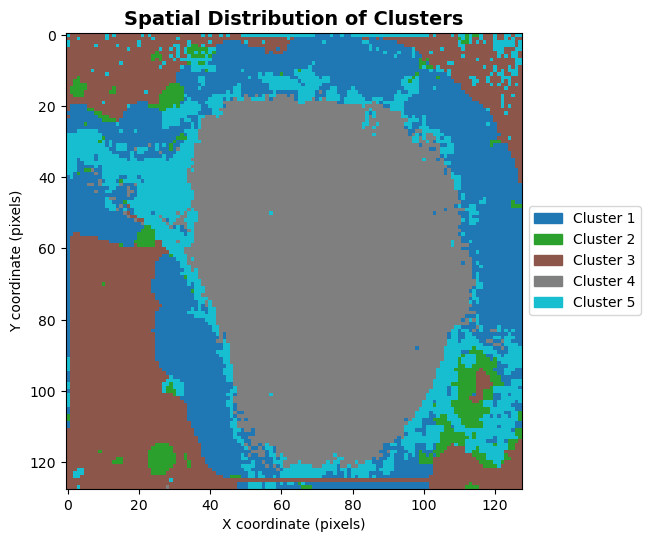

### Quantitative Evaluation

| Cluster | Farbe    | Anteil (%) | Vermutete Geweberegion          |
|----------|-----------|-------------|----------------------------------|
| 1        | Dunkelblau| 23,38 %     | Viabler Tumor                   |
| 2        | Grün      | 3,25 %      | Gelatine                        |
| 3        | Grau      | 21,14 %     | Nekrotischer Tumor              |
| 4        | Braun     | 39,51 %     | Glas                            |
| 5        | Hellblau  | 12,73 %     | Interface-Region                |


### Diskussion der Erkenntnisse

Die entstandenen Cluster lassen sich durchaus mit den aus der Aufgabenstellung bekannten Labels beschreiben. Folgende Vermutungen:
* Der zentrale graue Bereich (Cluster 3) könnte dem nekrotischen Tumor entsprechen, da dieser typischerweise im Zentrum liegt und ein gleichmäßiges Erscheinungsbild hat.
* Das umgebende hellblaue Gebiet (Cluster 5) könnte die Interface-Region zwischen vieablem und neukrotischem Gewebe darstellen.
* Die dunkelblauen Bereiche (Cluster 2) liegen weiter außen und sind unregelmäßiger, was  zur Charakteristik von viablen Tumorregionen passen könnte, die sich meist unregelmäßig um den Nekrosebereich herum befinden.
* Die braunen Bereiche (Cluster 4) finden sich hauptsächlich am Rand und können daher als Glas interpretiert werden.
* Die grünen Bereiche (Cluster 2) passen gut zu der Einbettung in Gelatine, die außerhalb der biologischen Strukturen sichtbar wird.

Insgesamt zeigt das Ergebnis, dass sich trotz der rein unüberwachten Methode die resultierenden Cluster gut mit den bekannten Gewebetypen in Beziehung setzen lassen. Man beachte allerdings, dass kleinere Abweichungen vorhanden sein könnten, beispielsweise verursacht durch Überlappungen der Klassen oder  Messrauschen.

Auch sollte man nicht außer Acht lassen, dass man zwingend das Wissen darüber braucht in wie viele Cluster man das Bild einteilen möchte (also k). In diesem Anwendungsgebiet ist das eventuell nicht immer klar, da man vielleicht nicht von Beginn an weiß, ob in der Gewebeprobe beispielsweise überhaupt Krebszellen enthalten sind und daher k vielleicht nur 4 oder 3 sein sollte.

# 4. Modeling & Evaluation: PCA und Alternativen

## 4.1 PCA (Principal Component Analysis)

### 4.1.1 Daten-Standardisierung 
-> Standardisierte Daten sind bereits aus kMeans vorhanden

### 4.1.2 Varianzanalyse



Input data shape: (16384, 191)
PCA output shape: (16384, 191)
Number of components: 191

=== TOP COMPONENTS BREAKDOWN ===
PC 1: 0.2152 (21.52%) - Cumulative: 0.2152 (21.52%)
PC 2: 0.1309 (13.09%) - Cumulative: 0.3460 (34.60%)
PC 3: 0.0428 ( 4.28%) - Cumulative: 0.3888 (38.88%)
PC 4: 0.0230 ( 2.30%) - Cumulative: 0.4119 (41.19%)
PC 5: 0.0182 ( 1.82%) - Cumulative: 0.4301 (43.01%)
PC 6: 0.0121 ( 1.21%) - Cumulative: 0.4422 (44.22%)
PC 7: 0.0093 ( 0.93%) - Cumulative: 0.4515 (45.15%)
PC 8: 0.0089 ( 0.89%) - Cumulative: 0.4603 (46.03%)
PC 9: 0.0083 ( 0.83%) - Cumulative: 0.4686 (46.86%)
PC10: 0.0082 ( 0.82%) - Cumulative: 0.4768 (47.68%)


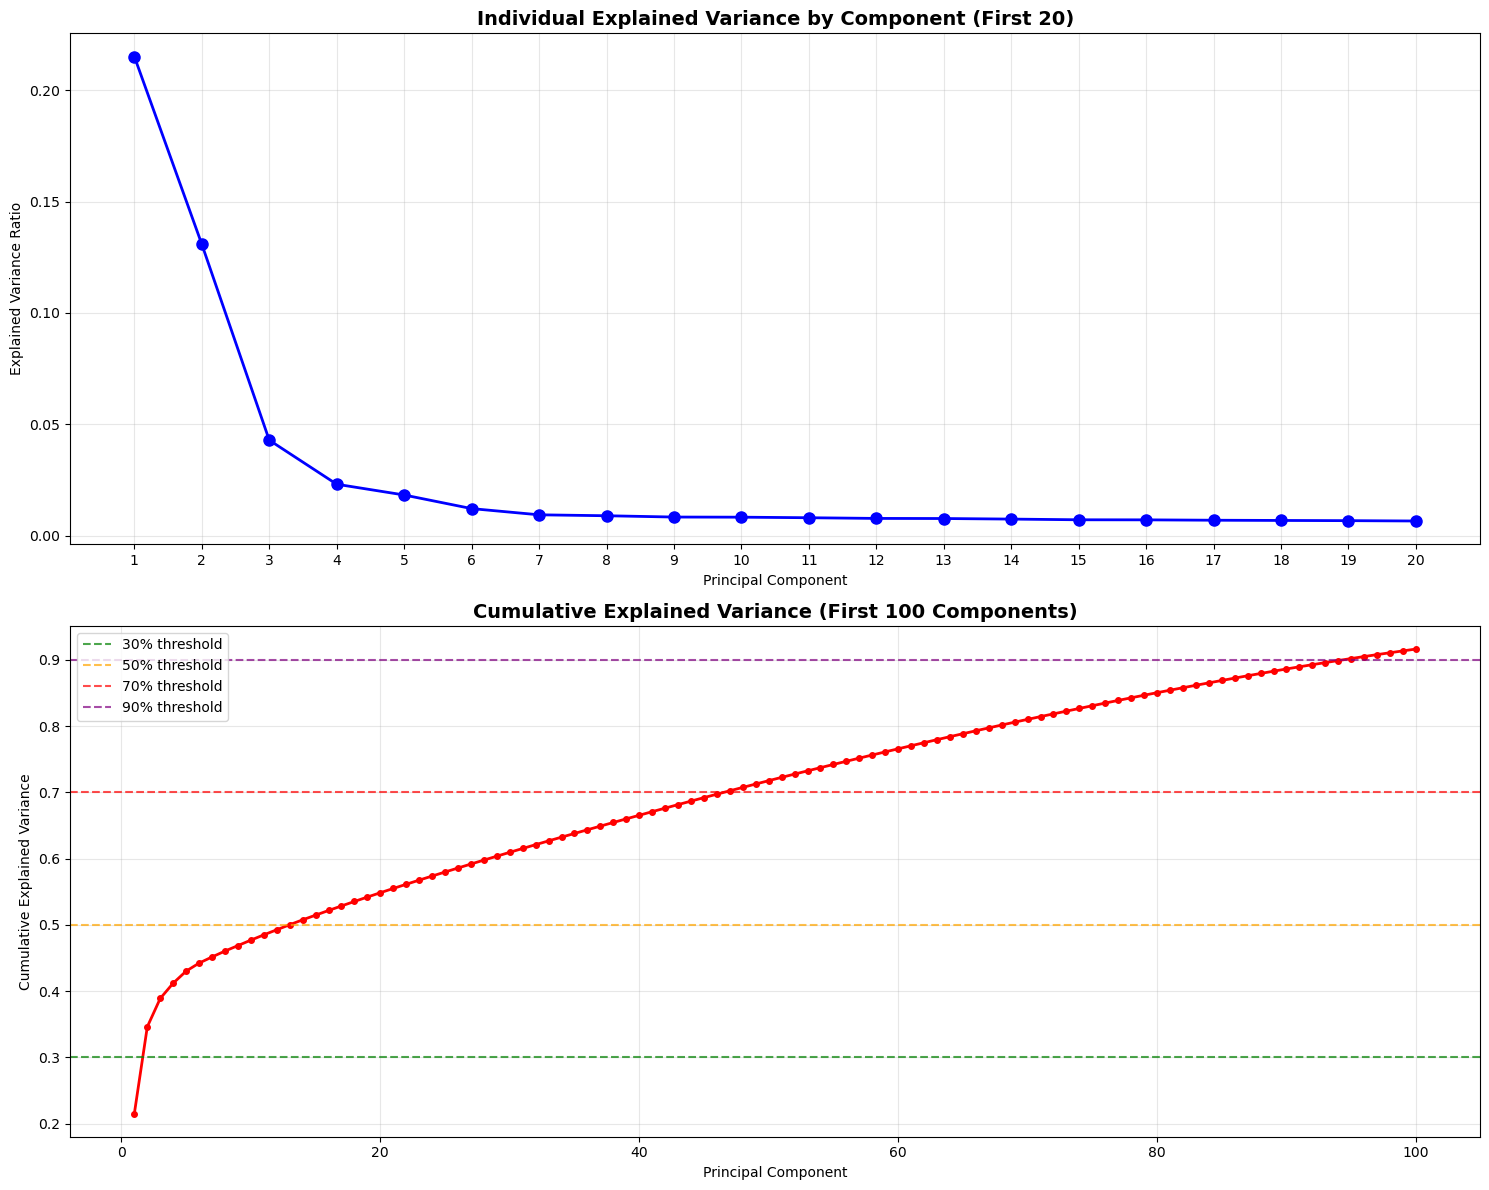

In [55]:
print(f"Input data shape: {X_scaled.shape}")

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"PCA output shape: {X_pca.shape}")
print(f"Number of components: {pca.n_components_}")

# Calculate explained variance metrics
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_
cumulative_variance = np.cumsum(explained_variance_ratio)


print(f"\n=== TOP COMPONENTS BREAKDOWN ===")
for i in range(min(10, len(explained_variance_ratio))):
	print(f"PC{i+1:2d}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:5.2f}%) "
		  f"- Cumulative: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:5.2f}%)")

# Quick visualization of individual variance contribution (first 20 components)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Individual variance for first 20 components
ax1.plot(range(1, 21), explained_variance_ratio[:20], 'bo-', linewidth=2, markersize=8)
ax1.set_title('Individual Explained Variance by Component (First 20)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 21))

# Bottom plot: Cumulative variance for first 100 components
n_components_plot = min(100, len(cumulative_variance))
ax2.plot(range(1, n_components_plot + 1), cumulative_variance[:n_components_plot], 'ro-', linewidth=2, markersize=4)
ax2.axhline(y=0.30, color='g', linestyle='--', alpha=0.7, label='30% threshold')
ax2.axhline(y=0.50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
ax2.axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='70% threshold')
ax2.axhline(y=0.90, color='purple', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_title('Cumulative Explained Variance (First 100 Components)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.8)  # Add space between plots
plt.tight_layout()
plt.show()

In [56]:
print(f"\n=== EXPLAINED VARIANCE ANALYSIS ===")
print(f"Total variance in original data: {np.sum(explained_variance):.3f}")

# Key thresholds for dimensionality reduction
variance_thresholds = [0.30, 0.40, 0.50, 0.70, 0.90]
for threshold in variance_thresholds:
	n_components = np.argmax(cumulative_variance >= threshold) + 1
	print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

# Transform back check (reconstruction accuracy)
print(f"\n=== RECONSTRUCTION ANALYSIS ===")
# Test reconstruction with different numbers of components
n_components_test = [5, 10, 20, 50]
for n_comp in n_components_test:
	if n_comp <= pca.n_components_:
		# Reconstruct using only first n components
		X_reconstructed = X_pca[:, :n_comp] @ pca.components_[:n_comp, :]
		reconstruction_error = np.mean((X_scaled - X_reconstructed)**2)
		print(f"Reconstruction error with {n_comp} components: {reconstruction_error:.6f} "
			  f"({cumulative_variance[n_comp-1]*100:.1f}% variance retained)")


=== EXPLAINED VARIANCE ANALYSIS ===
Total variance in original data: 157.010
Components needed for 30% variance: 2
Components needed for 40% variance: 4
Components needed for 50% variance: 13
Components needed for 70% variance: 47
Components needed for 90% variance: 95

=== RECONSTRUCTION ANALYSIS ===
Reconstruction error with 5 components: 0.468474 (43.0% variance retained)
Reconstruction error with 10 components: 0.430026 (47.7% variance retained)
Reconstruction error with 20 components: 0.371211 (54.8% variance retained)
Reconstruction error with 50 components: 0.232186 (71.8% variance retained)


### 4.1.3 Wahl Anzahl Hauptkomponenten
#### Elbow Methode

Geht man im Plot oberhalb mit der individuellen erklärten Varianz nach der Elbow-Regel: Man sucht also den Punkt, an dem die Kurve deutlich abflacht, so ergibt es Sinn die Anzahl auf maximal 4, vielleicht sogar nur 3 Hauptkomponenten zu beschränken.


### 4.1.4 Plotten der räumlichen Verteilung

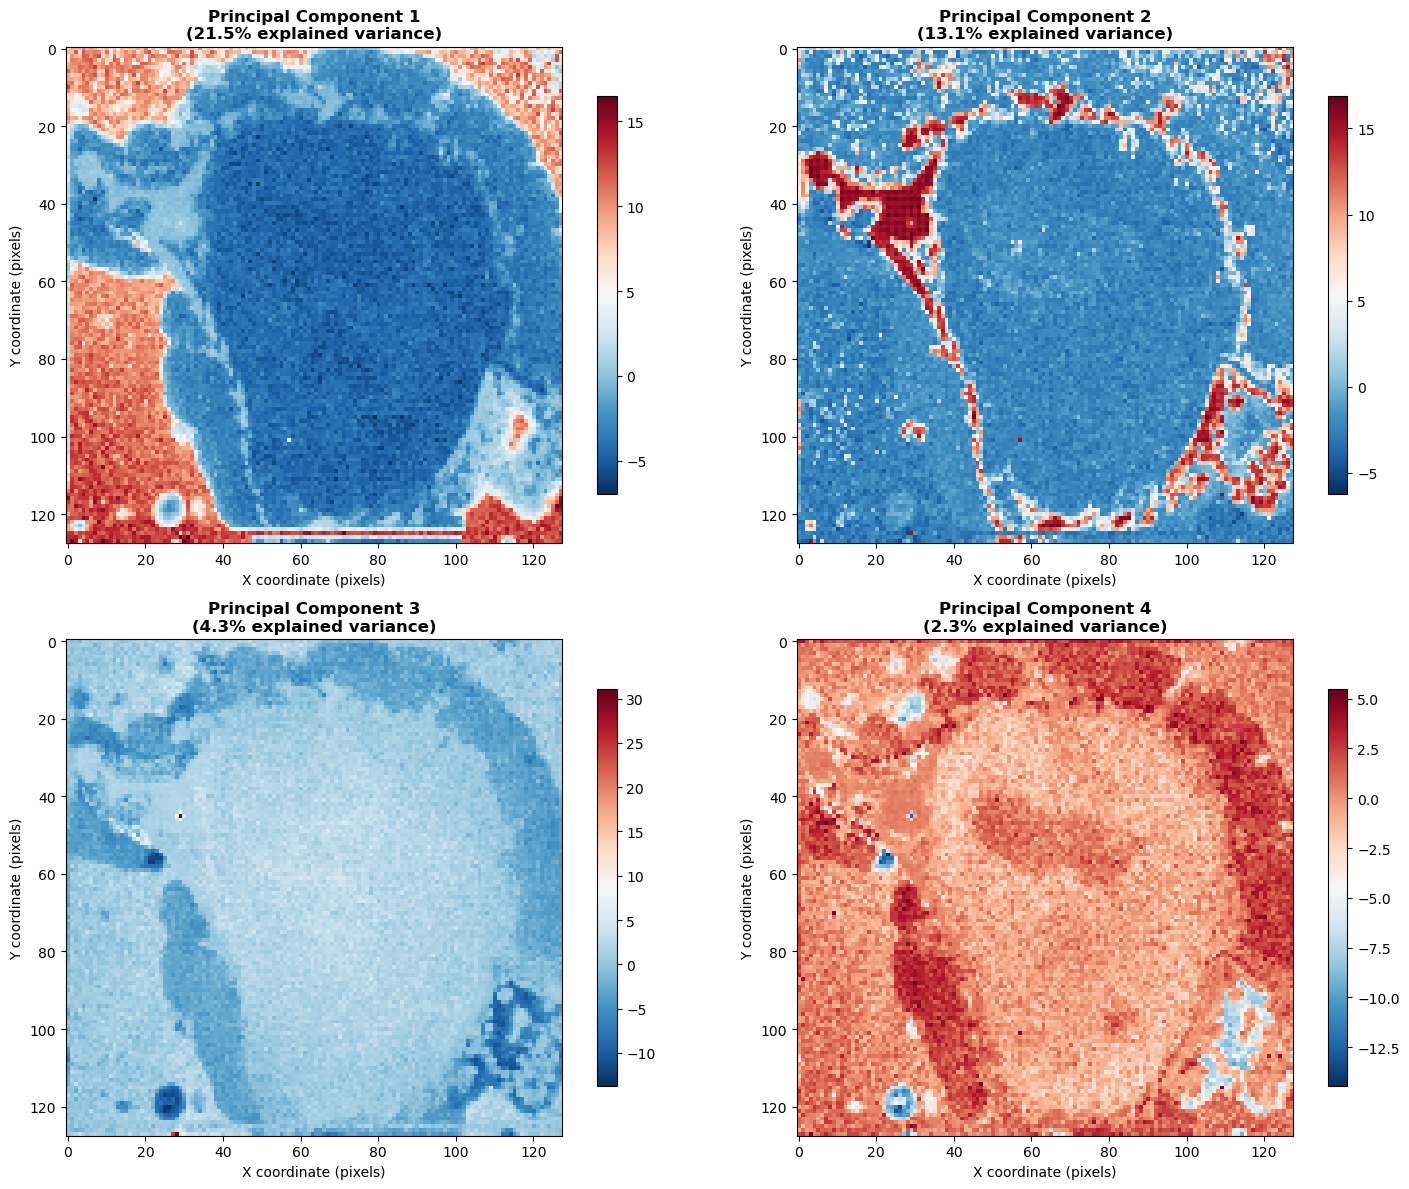

In [59]:
# Individual 128x128 spatial plots for PC 1-4
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i in range(4):
    row = i // 2
    col = i % 2
    
    # Reshape PC scores back to spatial dimensions
    pc_spatial = X_pca[:, i].reshape(height, image_width)
    
    # Create the plot
    im = axes[row, col].imshow(pc_spatial, cmap='RdBu_r', interpolation='nearest')
    axes[row, col].set_title(f'Principal Component {i+1}\n({explained_variance_ratio[i]:.1%} explained variance)', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

plt.tight_layout()
plt.show()


### 4.1.5 Ergebnisdiskussion

#### PC1 (21.5% erklärte Varianz)


**Räumliches Muster:** 
PC1 erfasst das dominanteste Muster im Datensatz. Es zeigt einen starken Kontrast zwischen dem zentralen Bereich (Blau, negativer Score) und der äußeren Umgebung (Rot, positiver Score).

**Deutung:** Dieses PC beschreibt die größte chemische Unterscheidung im Bild, also sehr wahrscheinlich die Trennung zwischen der biologischen Probe und dem Hintergrund bzw. dem Trägermaterial.


#### PC2 (13.1% erklärte Varianz)

**Räumliches Muster:** PC2, das orthogonal zu PC1 steht, erfasst die zweitgrößte Varianz. Das Muster fokussiert sich nun auf die Heterogenität innerhalb des zentralen Gewebes. Es trennt bestimmte Zwischenstrukturen (Rot) vom Rest des Gewebes (Blau).

**Deutung:** Dieses PC identifiziert die zweitgrößte chemische Unterscheidung im Bild, welche nun innerhalb des Gewebes ist. Daher erlaubt es nun, das Gewebe genauer zu untersuchen. Die Randbereiche die hier deutlich zu sehen sind könnten, wenn man es mit den Beispielen aus der Aufgabe vergleicht, die Interface-Region darstellen.


#### PC3 (4.3% erklärte Varianz)

**Räumliches Muster:** Das Muster ist weniger deutlich und zeigt subtile, fleckige Unterschiede im Gewebe. Alles ist im negativen, blauen Score Bereich.

**Deutung:** Die dunkleren Flecken tauchen eher am Rand auf, was im Vergleich zu den Beispielbildern Gelatine darstellen könnte. Die weniger intensiven Bereiche könnten verdeutlichen, dass die Gelatine überall in der Probe verteilt ist und nur an manchen stellen klar abgrenzbar ist.


#### PC4 (2.3% erklärte Varianz)

**Räumliches Muster:**
Dieses PC zeigt möglicherweise Tumorstrukturen (kleine rote Kreise), was auf eine Korrelation mit bestimmten Zelltypen hindeuten kann.
    * **PC5:** Das Muster wird **sehr fleckig und verrauscht**.
* **Zusammenhang:** Diese PCs repräsentieren die **geringfügigsten chemischen Variationen**. **PC4** könnte noch auf spezifische morphologische Strukturen hinweisen, während **PC5** wahrscheinlich dominierendes Rauschen ist.

---

### 🤝 Gesamtzusammenhang

Die PCs zerlegen die komplexe MSI-Information in eine Reihe **linear unkorrelierter (unabhängiger) Muster**, geordnet nach der Größe ihres Beitrags zur Gesamtvarianz:

1.  **PC1:** Trennung der Hauptkomponenten (Gewebe vs. Umgebung).
2.  **PC2:** Wichtigste interne Heterogenität.
3.  **Nachfolgende PCs (PC3, PC4...):** Zunehmend feinere Details und Rauschen.

Um die Interpretation abzuschließen, müssen die **Farbmuster** in diesen Scores Images mit den **m/z-Werten** (Peaks) in den **Loadings** der jeweiligen PC verknüpft werden. Die Peaks mit hohen Ladungen sind die **Moleküle**, die diese räumlichen Muster definieren.

### 4.1.6 Vor- und Nachteile des Ansatzes

Vorteile: man weiß wie viel % der Informationen man erhalten hat

## 4.2 NMF (Non-negative Matrix Factorization)

### 4.1.1 Daten-Standardisierung 
-> auch hier: Standardisierte Daten sind bereits aus kMeans vorhanden

### 4.1.2 Varianzanalyse



=== NON-NEGATIVE MATRIX FACTORIZATION ===
Input data shape: (16384, 191)
Data shifted to non-negative range: [0.000, 57.683]
NMF output shape: (16384, 5)


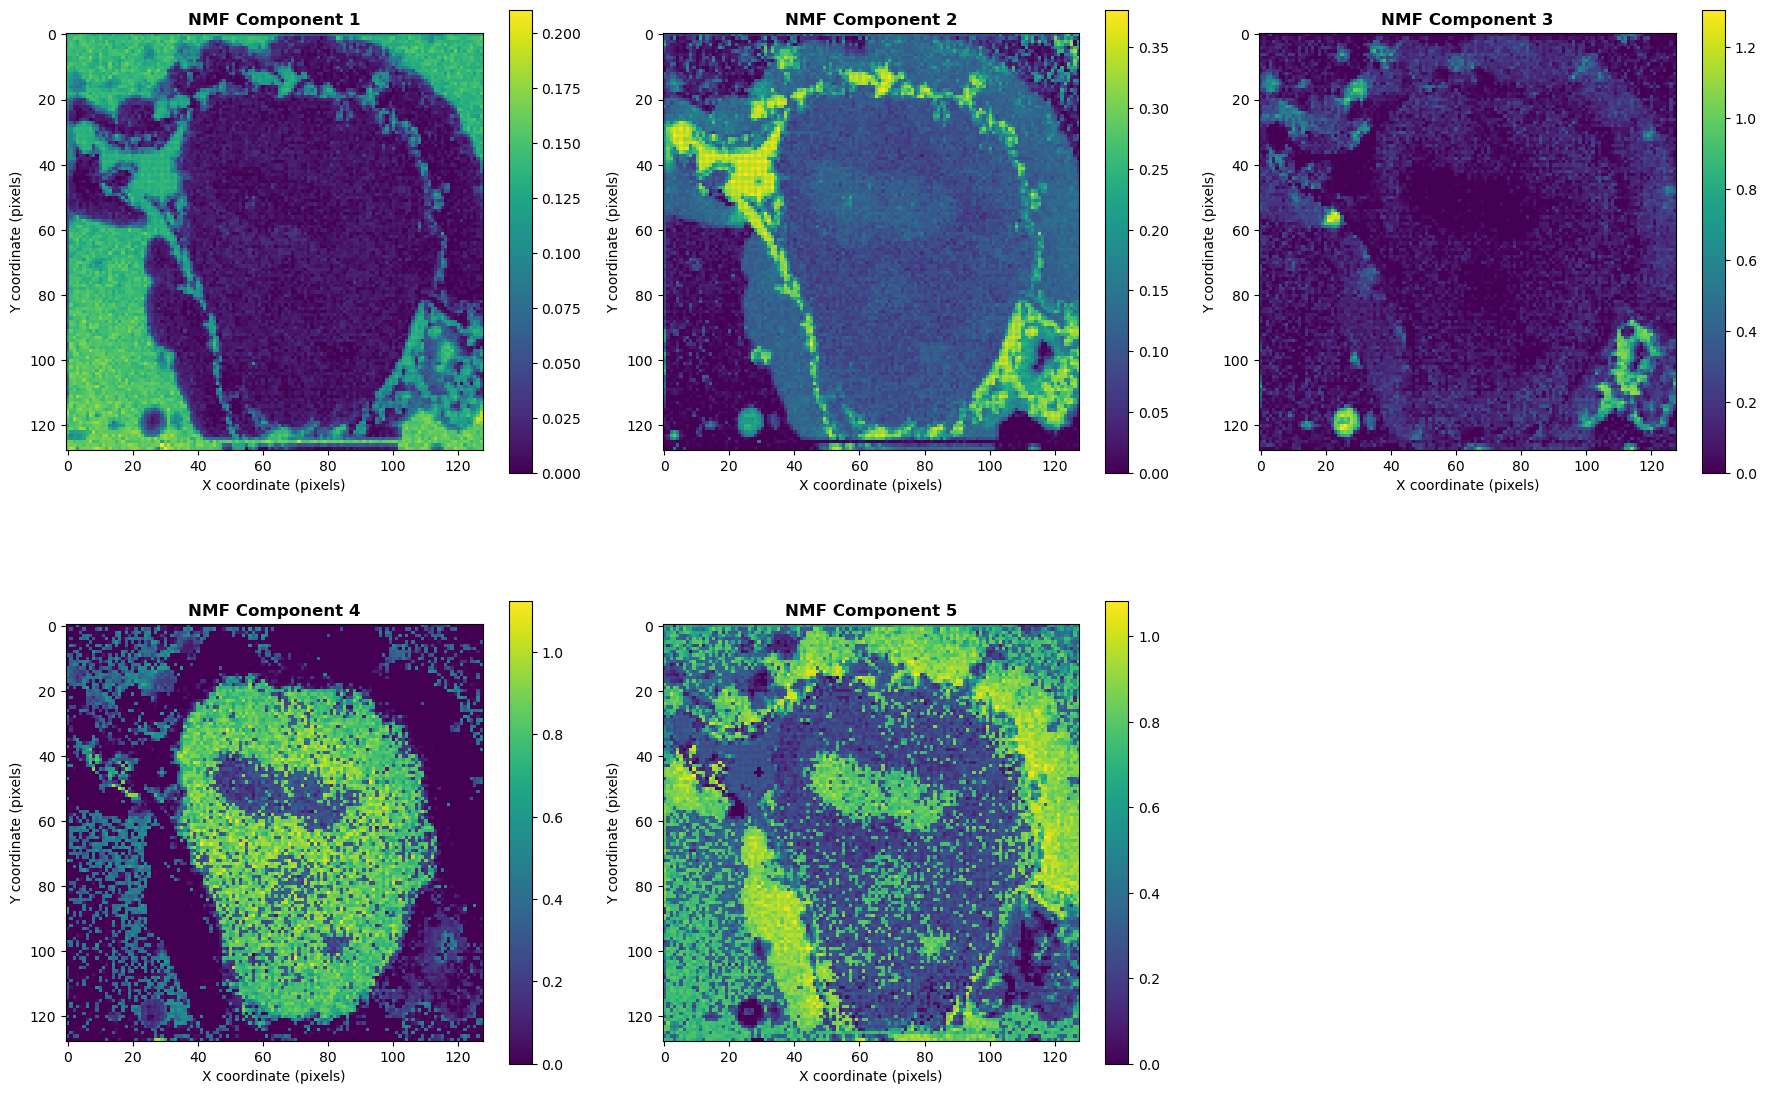

In [61]:
# Perform NMF on standardized data
print("=== NON-NEGATIVE MATRIX FACTORIZATION ===")
print(f"Input data shape: {X_scaled.shape}")

# NMF requires non-negative data, so we need to shift the standardized data
# Add the minimum value to make all values non-negative
X_shifted = X_scaled - np.min(X_scaled)
print(f"Data shifted to non-negative range: [{np.min(X_shifted):.3f}, {np.max(X_shifted):.3f}]")

# Apply NMF with reduced dimensionality
n_components_nmf = 5  # Use same number of components as ICA for comparison

# Apply NMF
nmf = NMF(n_components=5, random_state=42, max_iter=1000)
X_nmf = nmf.fit_transform(X_shifted)

print(f"NMF output shape: {X_nmf.shape}")


# Plot the top 5 NMF components spatially
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(5):
    row = i // 3
    col = i % 3
    
    # Reshape NMF scores back to spatial dimensions
    nmf_spatial = X_nmf[:, i].reshape(height, image_width)
    
    # Create the plot
    im = axes[row, col].imshow(nmf_spatial, cmap='viridis', interpolation='nearest')
    axes[row, col].set_title(f'NMF Component {i+1}', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

# Hide the last subplot since we only have 5 components
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()


=== NMF RECONSTRUCTION & CUMULATIVE ANALYSIS ===
Baseline error (no components): 0.821990
Calculating reconstruction errors for 1 to 20 components...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(



=== TOP COMPONENTS BREAKDOWN (NMF) ===
NMF 1: Error=0.794434, Quality=0.0335 ( 3.35%)
NMF 2: Error=0.619356, Quality=0.2465 (24.65%)
NMF 3: Error=0.534035, Quality=0.3503 (35.03%)
NMF 4: Error=0.503157, Quality=0.3879 (38.79%)
NMF 5: Error=0.487731, Quality=0.4066 (40.66%)
NMF 6: Error=0.484010, Quality=0.4112 (41.12%)
NMF 7: Error=0.470802, Quality=0.4272 (42.72%)
NMF 8: Error=0.462587, Quality=0.4372 (43.72%)
NMF 9: Error=0.458908, Quality=0.4417 (44.17%)
NMF10: Error=0.458001, Quality=0.4428 (44.28%)


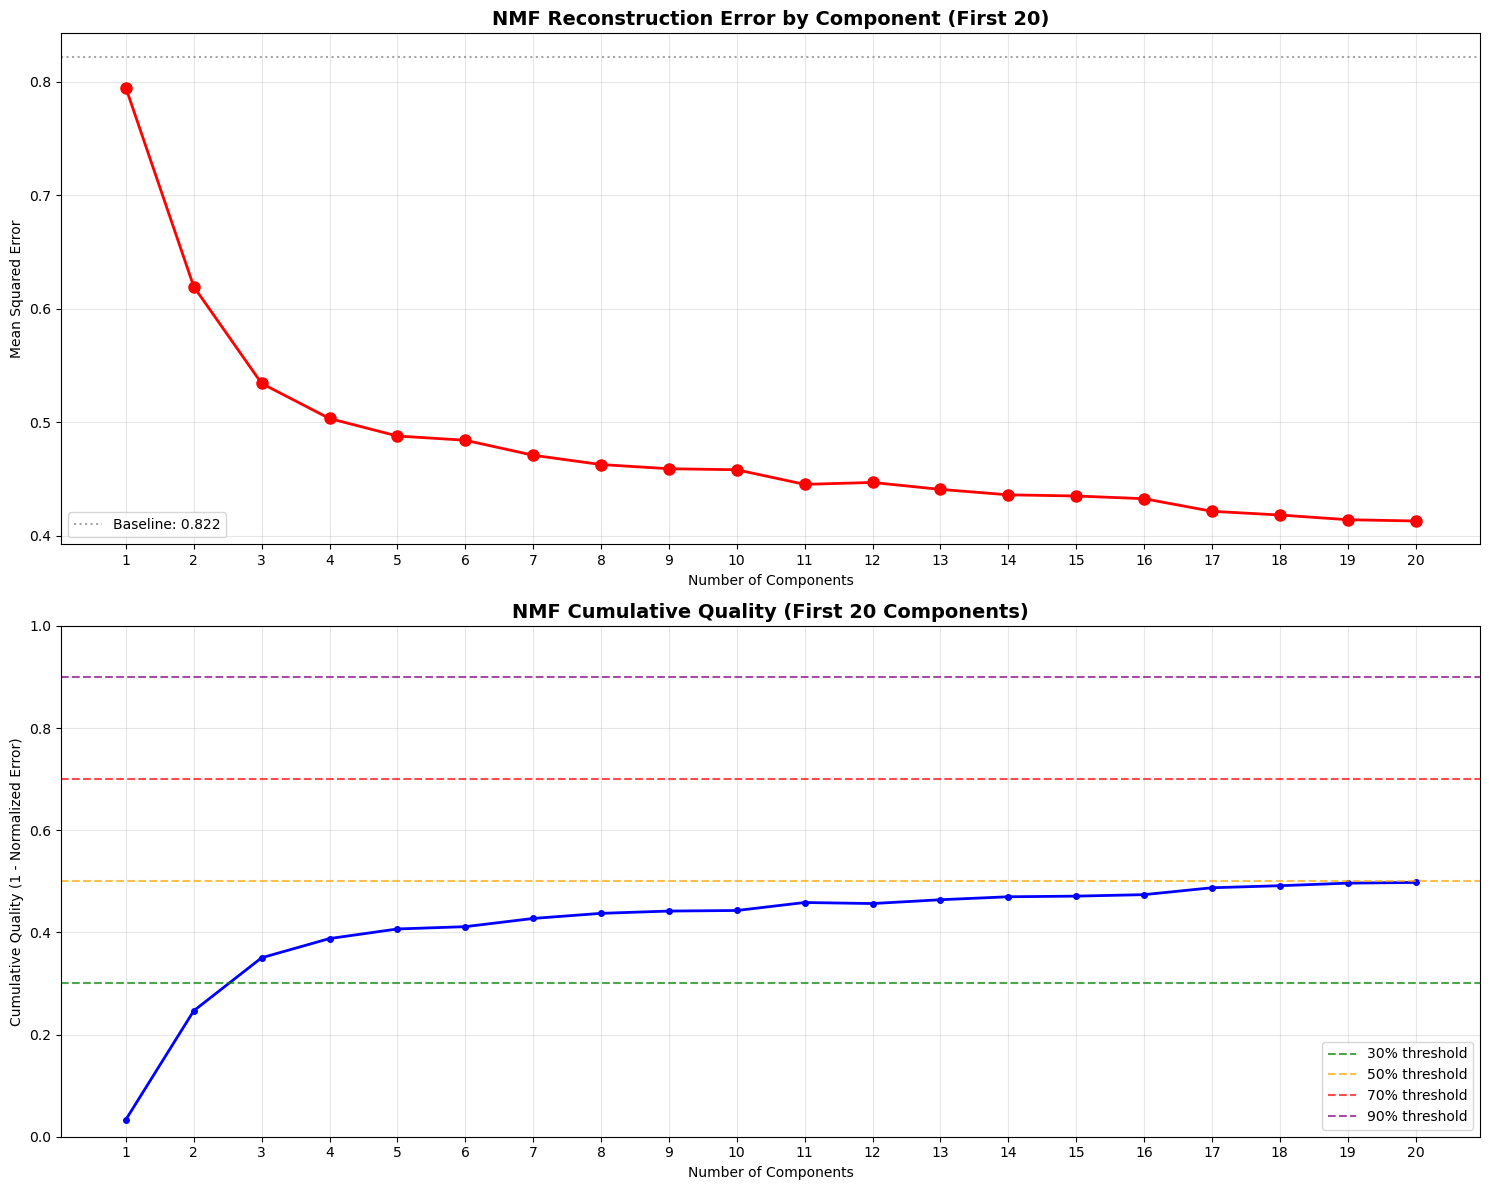

In [62]:
print(f"\n=== NMF RECONSTRUCTION & CUMULATIVE ANALYSIS ===")

# For NMF, we need to calculate a different type of cumulative analysis
# since NMF doesn't have explained variance like PCA

# Calculate baseline error (no reconstruction - just using mean)
baseline_error = np.mean((X_shifted - np.mean(X_shifted))**2)
print(f"Baseline error (no components): {baseline_error:.6f}")

# Calculate reconstruction errors for different numbers of components (1 to 20)
max_components = min(20, n_channels)
reconstruction_errors = []
cumulative_quality = []
components_range = range(1, max_components + 1)

print(f"Calculating reconstruction errors for 1 to {max_components} components...")

for n_comp in components_range:
    # Fit NMF with n_comp components
    nmf_temp = NMF(n_components=n_comp, random_state=42, max_iter=500)
    X_temp = nmf_temp.fit_transform(X_shifted)
    X_reconstructed = X_temp @ nmf_temp.components_
    
    # Calculate reconstruction error
    error = np.mean((X_shifted - X_reconstructed)**2)
    reconstruction_errors.append(error)
    
    # Calculate cumulative quality (1 - normalized error relative to baseline)
    normalized_error = error / baseline_error
    cumulative_quality.append(1 - normalized_error)

print(f"\n=== TOP COMPONENTS BREAKDOWN (NMF) ===")
for i in range(min(10, len(reconstruction_errors))):
    print(f"NMF{i+1:2d}: Error={reconstruction_errors[i]:.6f}, Quality={cumulative_quality[i]:.4f} ({cumulative_quality[i]*100:5.2f}%)")

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Reconstruction error for first 20 components
ax1.plot(range(1, len(reconstruction_errors) + 1), reconstruction_errors, 'ro-', linewidth=2, markersize=8)
ax1.axhline(y=baseline_error, color='gray', linestyle=':', alpha=0.7, label=f'Baseline: {baseline_error:.3f}')
ax1.set_title('NMF Reconstruction Error by Component (First 20)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Mean Squared Error')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(reconstruction_errors) + 1))
ax1.legend()

# Bottom plot: Cumulative quality for first 20 components
ax2.plot(range(1, len(cumulative_quality) + 1), cumulative_quality, 'bo-', linewidth=2, markersize=4)
ax2.axhline(y=0.30, color='g', linestyle='--', alpha=0.7, label='30% threshold')
ax2.axhline(y=0.50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
ax2.axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='70% threshold')
ax2.axhline(y=0.90, color='purple', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_title('NMF Cumulative Quality (First 20 Components)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Quality (1 - Normalized Error)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(1, len(cumulative_quality) + 1))

plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

=== NON-NEGATIVE MATRIX FACTORIZATION ===
Input data shape: (16384, 191)
Data shifted to non-negative range: [0.000, 57.683]
NMF output shape: (16384, 5)
NMF converged after 74 iterations

=== NMF COMPONENT ANALYSIS ===
Component Statistics:
Component 1: norm=184.289, mean=0.056, var=0.003
Component 2: norm=89.428, mean=0.116, var=0.006
Component 3: norm=42.104, mean=0.129, var=0.026
Component 4: norm=54.456, mean=0.337, var=0.126
Component 5: norm=61.161, mean=0.499, var=0.087


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


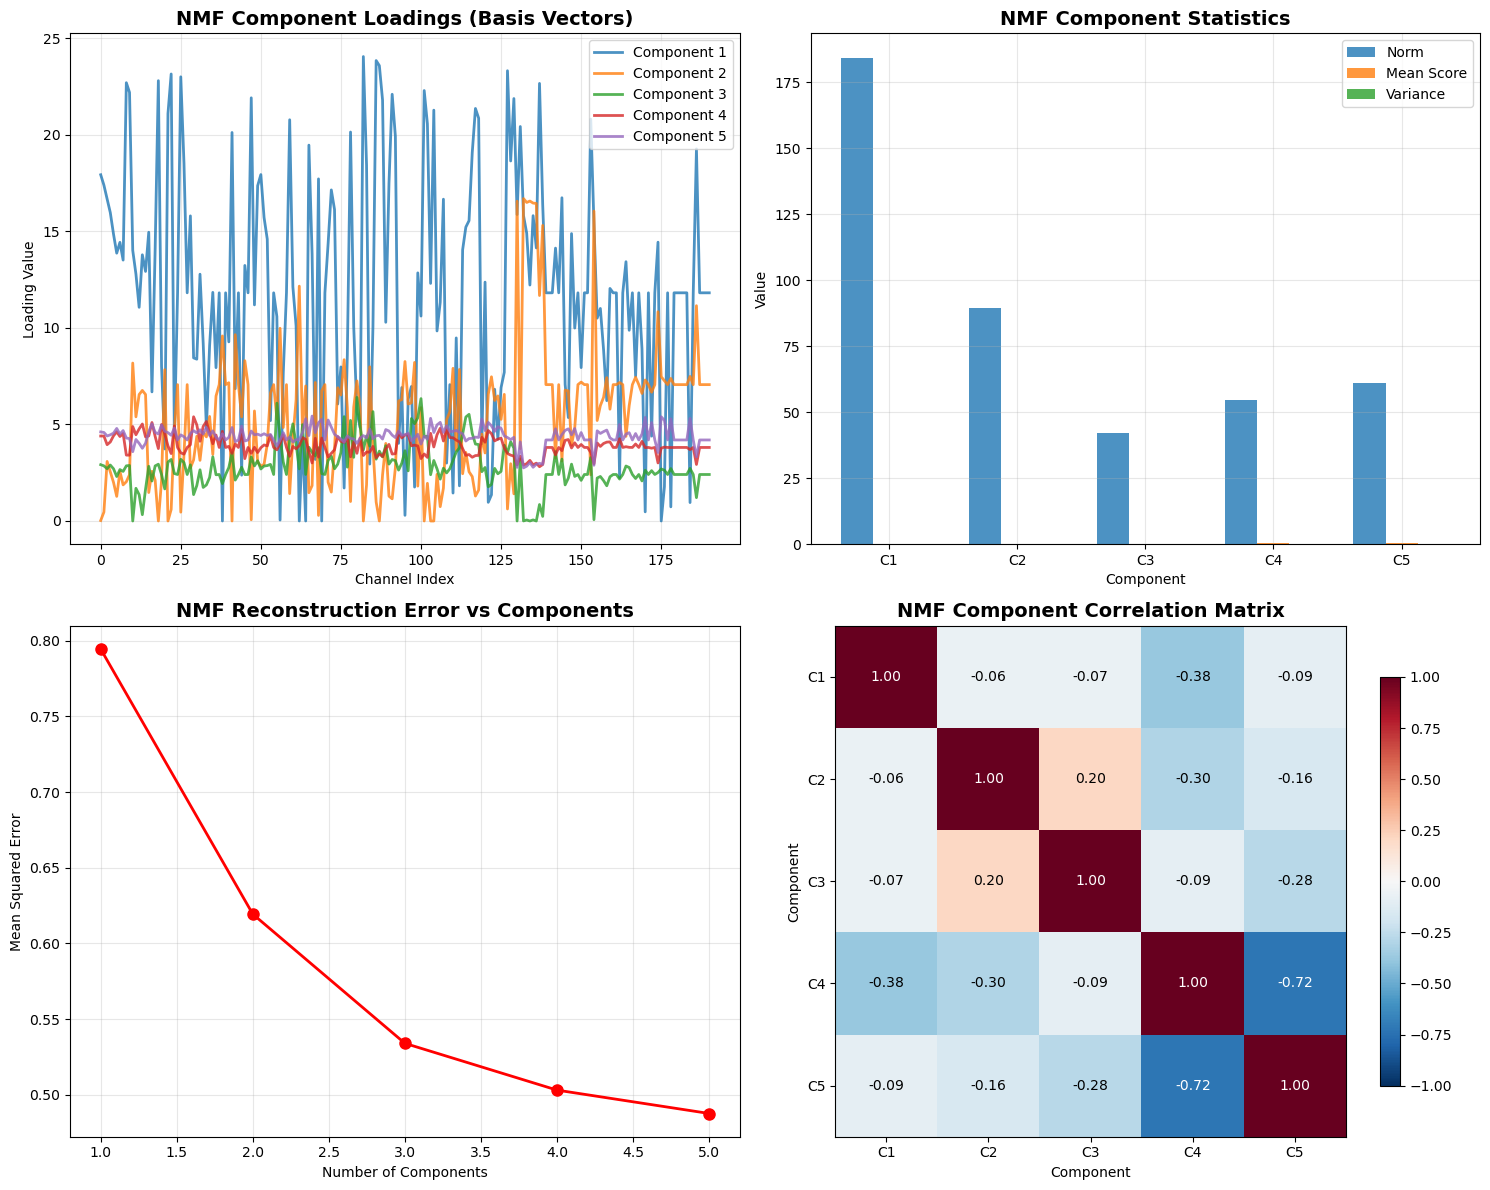


=== NMF QUALITY METRICS ===
Overall reconstruction error: 0.487731
Component sparsity (% zeros): [2.61780105 4.18848168 2.09424084 0.         0.        ]
Score sparsity (% zeros): [ 4.69360352  4.85229492 16.67480469 33.48388672  0.8972168 ]


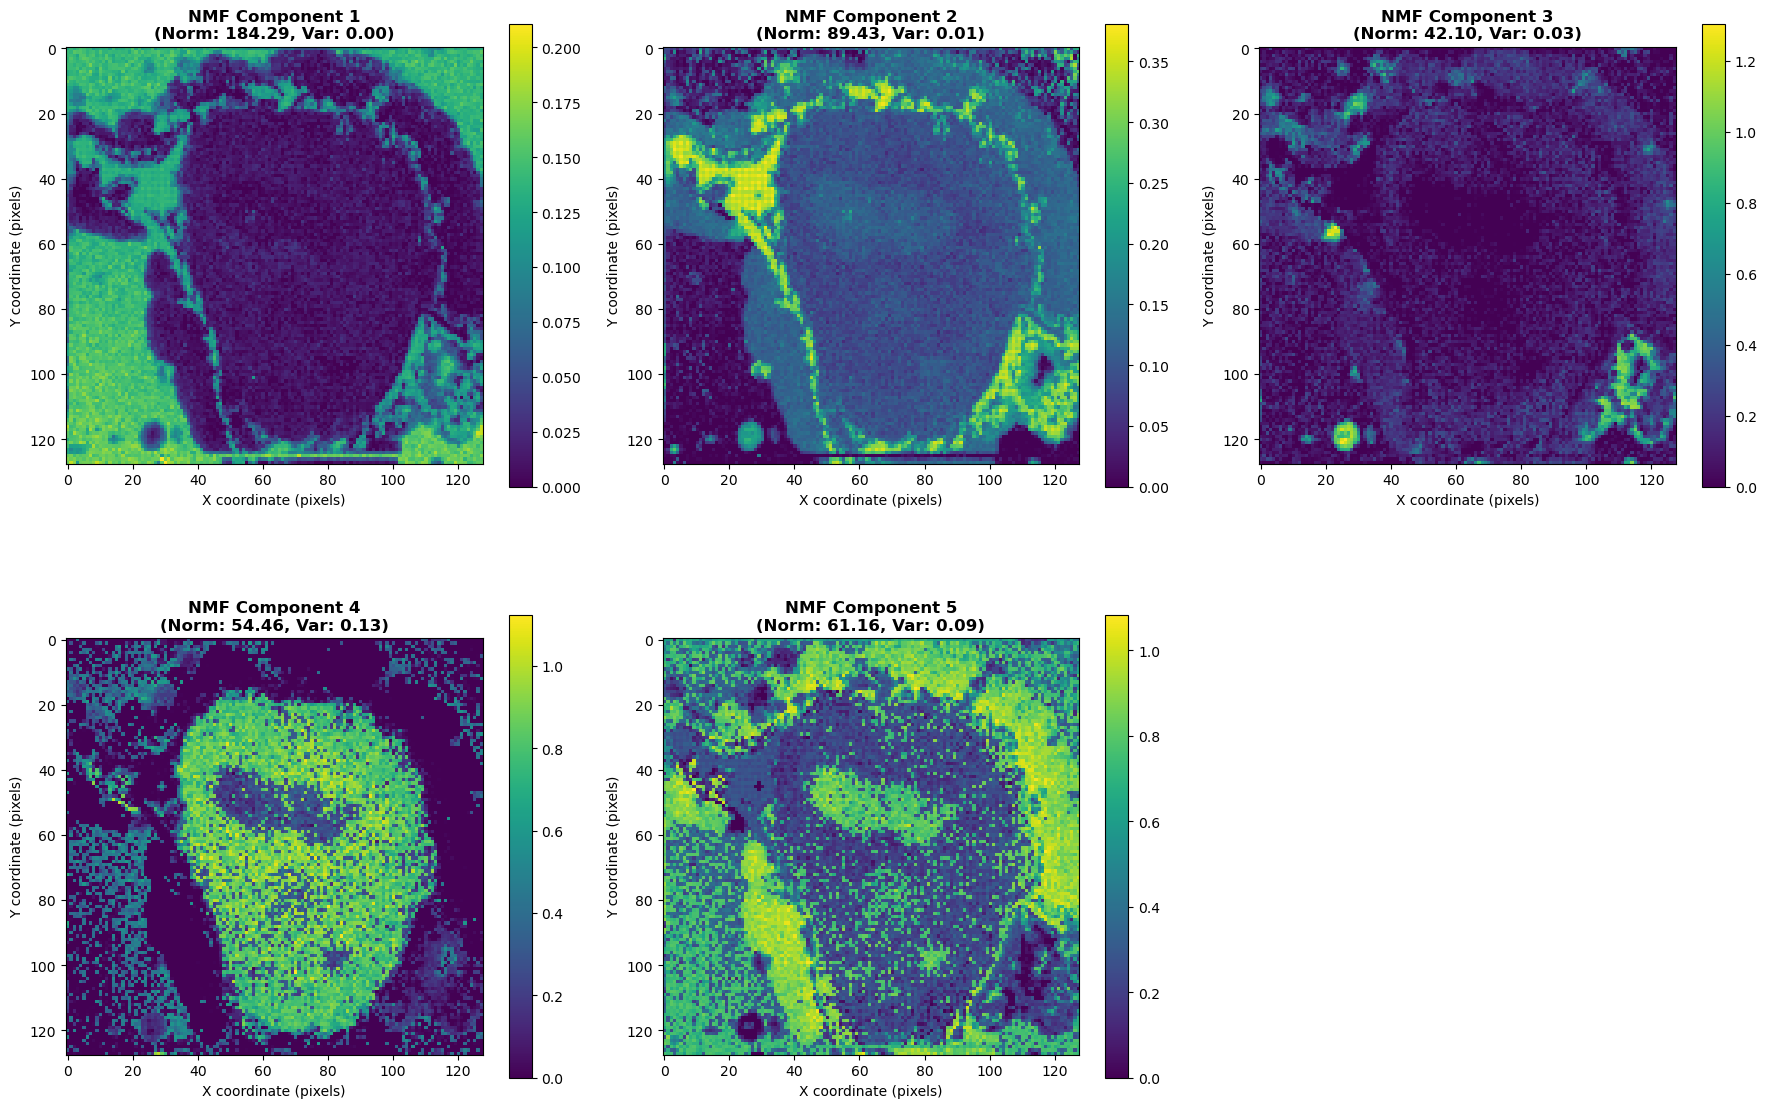

In [17]:
# Perform NMF on standardized data
print("=== NON-NEGATIVE MATRIX FACTORIZATION ===")
print(f"Input data shape: {X_scaled.shape}")

# NMF requires non-negative data, so we need to shift the standardized data
# Add the minimum value to make all values non-negative
X_shifted = X_scaled - np.min(X_scaled)
print(f"Data shifted to non-negative range: [{np.min(X_shifted):.3f}, {np.max(X_shifted):.3f}]")

# Apply NMF with reduced dimensionality
n_components_nmf = 5  # Use same number of components as ICA for comparison

# Apply NMF
nmf = NMF(n_components=5, random_state=42, max_iter=1000)
X_nmf = nmf.fit_transform(X_shifted)

print(f"NMF output shape: {X_nmf.shape}")
print(f"NMF converged after {nmf.n_iter_} iterations")

# === ZWISCHENVISUALISIERUNG: NMF ANALYSIS ===
print(f"\n=== NMF COMPONENT ANALYSIS ===")

# Calculate component statistics
component_norms = np.linalg.norm(nmf.components_, axis=1)
component_means = np.mean(X_nmf, axis=0)
component_vars = np.var(X_nmf, axis=0)

print("Component Statistics:")
for i in range(5):
    print(f"Component {i+1}: norm={component_norms[i]:.3f}, mean={component_means[i]:.3f}, var={component_vars[i]:.3f}")

# Visualization of NMF analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Component loadings (basis vectors)
ax1 = axes[0, 0]
for i in range(5):
    ax1.plot(nmf.components_[i], label=f'Component {i+1}', linewidth=2, alpha=0.8)
ax1.set_title('NMF Component Loadings (Basis Vectors)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Channel Index')
ax1.set_ylabel('Loading Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Component statistics comparison
ax2 = axes[0, 1]
x_pos = np.arange(5)
width = 0.25
ax2.bar(x_pos - width, component_norms, width, label='Norm', alpha=0.8)
ax2.bar(x_pos, component_means, width, label='Mean Score', alpha=0.8)
ax2.bar(x_pos + width, component_vars, width, label='Variance', alpha=0.8)
ax2.set_title('NMF Component Statistics', fontsize=14, fontweight='bold')
ax2.set_xlabel('Component')
ax2.set_ylabel('Value')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'C{i+1}' for i in range(5)])
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Reconstruction error analysis
ax3 = axes[1, 0]
# Calculate reconstruction for different numbers of components
reconstruction_errors = []
components_range = range(1, 6)

for n_comp in components_range:
    nmf_temp = NMF(n_components=n_comp, random_state=42, max_iter=1000)
    X_temp = nmf_temp.fit_transform(X_shifted)
    X_reconstructed = X_temp @ nmf_temp.components_
    error = np.mean((X_shifted - X_reconstructed)**2)
    reconstruction_errors.append(error)

ax3.plot(components_range, reconstruction_errors, 'ro-', linewidth=2, markersize=8)
ax3.set_title('NMF Reconstruction Error vs Components', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('Mean Squared Error')
ax3.grid(True, alpha=0.3)

# 4. Component correlation matrix
ax4 = axes[1, 1]
component_corr = np.corrcoef(X_nmf.T)
im = ax4.imshow(component_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax4.set_title('NMF Component Correlation Matrix', fontsize=14, fontweight='bold')
ax4.set_xlabel('Component')
ax4.set_ylabel('Component')
ax4.set_xticks(range(5))
ax4.set_yticks(range(5))
ax4.set_xticklabels([f'C{i+1}' for i in range(5)])
ax4.set_yticklabels([f'C{i+1}' for i in range(5)])

# Add correlation values as text
for i in range(5):
    for j in range(5):
        ax4.text(j, i, f'{component_corr[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(component_corr[i, j]) > 0.5 else 'black')

plt.colorbar(im, ax=ax4, shrink=0.8)

plt.tight_layout()
plt.show()

# Additional analysis
print(f"\n=== NMF QUALITY METRICS ===")
X_reconstructed = X_nmf @ nmf.components_
reconstruction_error = np.mean((X_shifted - X_reconstructed)**2)
print(f"Overall reconstruction error: {reconstruction_error:.6f}")

# Sparsity analysis
sparsity_components = np.mean(nmf.components_ == 0, axis=1)
sparsity_scores = np.mean(X_nmf == 0, axis=0)
print(f"Component sparsity (% zeros): {sparsity_components * 100}")
print(f"Score sparsity (% zeros): {sparsity_scores * 100}")

# Plot the top 5 NMF components spatially
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Calculate the correct width from the data shape
# X_nmf.shape[0] should equal height * width, so width = X_nmf.shape[0] / height
actual_width = X_nmf.shape[0] // height
image_width = ims_cube.shape[2] if 'ims_cube' in locals() else actual_width

for i in range(5):
    row = i // 3
    col = i % 3
    
    # Reshape NMF scores back to spatial dimensions
    nmf_spatial = X_nmf[:, i].reshape(height, actual_width)
    
    # Create the plot
    im = axes[row, col].imshow(nmf_spatial, cmap='viridis', interpolation='nearest')
    axes[row, col].set_title(f'NMF Component {i+1}\n(Norm: {component_norms[i]:.2f}, Var: {component_vars[i]:.2f})', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

# Hide the last subplot since we only have 5 components
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()